In [ ]:
import numpy as np
import scipy
import glob
from scipy.io import loadmat

PATH = './test_data'


In [ ]:
files = glob.glob(PATH + '/*.mat')

test_data = []
for f in files:
    d = loadmat(f)
    test_data.append(d)


In [402]:
d = test_data[0]
t_gt = d['gt']
t_ms = d['ms']
t_lms = d['lms']
t_pan = d['pan']


def print_shape(*args, **kwargs):
    for i in args:
        print(i.shape)


print_shape(t_gt, t_ms, t_lms, t_pan)

(256, 256, 8)
(64, 64, 8)
(256, 256, 8)
(256, 256)


In [ ]:
import h5py

train_data = h5py.File('training_data/train_small.h5')
val_data = h5py.File('training_data/valid_small.h5')

In [ ]:
import cv2

img = np.asarray(train_data['pan'])[0]
cv2.GaussianBlur(img.transpose(1, 2, 0), (5, 5), 1.5)[..., np.newaxis].transpose(2, 0, 1).shape

# 可视化gt

(256, 256, 8)


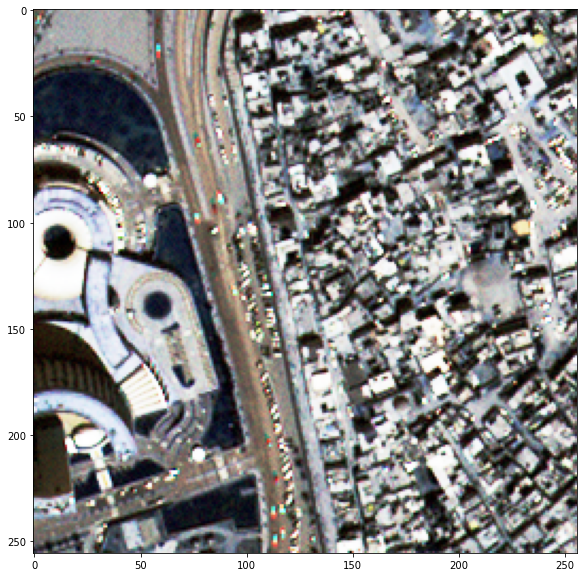

In [377]:
import matplotlib.pyplot as plt
import cv2


def viz(gt, figsize=(10, 10)):
    # gt shape should be [H, W, C]
    print(gt.shape)
    viz_gt = gt[..., :3]
    viz_gt = viz_gt - viz_gt.min((0, 1))
    viz_gt = viz_gt / viz_gt.max((0, 1))
    viz_gt *= 255
    viz_gt = viz_gt.astype('uint8')
    for i in range(3):
        viz_gt[..., i] = cv2.equalizeHist(viz_gt[..., i])
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(viz_gt)


viz(t_gt)

# 定义datasets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as T

import os.path as osp


class PansharpeningDatasets(data.Dataset):
    def __init__(self, base_path, train=True):
        self.files = glob.glob(osp.join(base_path, 'training_data'))
        self.train_data = h5py.File('training_data/train_small.h5')
        self.val_data = h5py.File('training_data/valid_small.h5')

        if train:
            self.gt, self.ms, self.lms, self.pan = self.get_divided(self.train_data)
        else:
            self.gt, self.ms, self.lms, self.pan = self.get_divided(self.val_data)

        # highpass filter
        self.group_high_pass()

        # to tensor
        self.pan = torch.tensor(self.pan) / 2047.
        self.ms = torch.tensor(self.ms) / 2047.
        self.lms = torch.tensor(self.lms) / 2047.
        self.gt = torch.tensor(self.gt) / 2047.

        # geometrical transformation
        self.geo_trans = T.Compose([
            T.RandomAffine((0, 30), (0.1, 0.3), (1, 1.5))
        ])

    @staticmethod
    def get_divided(data):
        return (np.asarray(data['gt']),
                np.asarray(data['ms']),
                np.asarray(data['lms']),
                np.asarray(data['pan'])
                )

    @staticmethod
    def _get_high_pass(data):
        for i, img in enumerate(data):
            hp = cv2.boxFilter(img.transpose(1, 2, 0), -1, (5, 5))
            if hp.ndim == 2:
                hp = hp[..., np.newaxis]
            data[i] = img - hp.transpose(2, 0, 1)
        return data

    def group_high_pass(self):
        self.ms = self._get_high_pass(self.ms)
        self.pan = self._get_high_pass(self.pan)

    def aug_trans(self, *data):
        data_list = []
        seed = torch.random.seed()
        for d in data:
            torch.manual_seed(seed)
            d = self.geo_trans(d)
            data_list.append(d)
        return data_list

    def __getitem__(self, item):
        tuple_data = (self.pan[item], self.ms[item], self.lms[item], self.gt[item])
        return self.aug_trans(*tuple_data)

    def __len__(self):
        return self.pan.shape[0]


train_datasets = PansharpeningDatasets('training_data', train=True)
val_datasets = PansharpeningDatasets('training_data', train=False)

train_dl = data.DataLoader(train_datasets, batch_size=16, shuffle=True)
val_dl = data.DataLoader(val_datasets, batch_size=16, shuffle=False)

for pan, ms, lms, gt in train_dl:
    print_shape(pan, ms, lms, gt)
    break

# 定义网络

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, ksize, stride, pad, bias=True):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, ksize, stride, pad, bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, ksize, stride, pad),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return self.relu(out + x)


class Resblock(nn.Module):
    def __init__(self):
        super(Resblock, self).__init__()

        channel = 32
        self.conv1 = nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1,
                               bias=True)
        self.conv2 = nn.Conv2d(in_channels=channel, out_channels=channel, kernel_size=3, stride=1, padding=1,
                               bias=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):  # x= hp of ms; y = hp of pan
        rs1 = self.relu(self.conv1(x))  # Bsx32x64x64
        rs1 = self.conv2(rs1)  # Bsx32x64x64
        rs = torch.add(x, rs1)  # Bsx32x64x64
        return rs


In [ ]:
from timm.models.layers import trunc_normal_


class PANNet(nn.Module):
    def __init__(self, in_c, hidden_c=32):
        super(PANNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_c + 1, out_channels=hidden_c, kernel_size=3, stride=1, padding=1,
                               bias=True)

        _res_block_params = dict(in_c=hidden_c, out_c=hidden_c, ksize=(3, 3), stride=1, pad=1)
        self.res1 = ResBlock(**_res_block_params)
        self.res2 = ResBlock(**_res_block_params)
        self.res3 = ResBlock(**_res_block_params)
        self.res4 = ResBlock(**_res_block_params)

        self.conv2 = nn.Conv2d(in_channels=hidden_c, out_channels=in_c, kernel_size=3, stride=1, padding=1,
                               bias=True)
        self.relu = nn.ReLU()
        self.deconv = nn.ConvTranspose2d(in_channels=in_c, out_channels=in_c, kernel_size=8, stride=4,
                                         padding=2, bias=True)
        self.backbone = nn.Sequential(
            self.res1,
            self.res2,
            self.res3,
            self.res4
        )

        self.apply(self.weight_init)

    def weight_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)

    def forward(self, ms, pan):
        output_deconv = self.deconv(ms)  # Bsx8x64x64

        input = torch.cat([output_deconv, pan], 1)  # Bsx9x64x64

        rs = self.relu(self.conv1(input))  # Bsx32x64x64

        rs = self.backbone(rs)  # ResNet's backbone! # Bsx32x64x64

        output = self.conv2(rs)  # Bsx8x64x64
        return output


ms = torch.randn(16, 8, 16, 16)
pan = torch.randn(16, 1, 64, 64)
pannet = PANNet(8, 32)
pannet(ms, pan).shape

# 开始训练

In [ ]:
epochs = 500
init_lr = 1e-4
end_lr = 1e-6
cos_lr_T_max = 80
device = 'cuda:0'

optim = torch.optim.AdamW(pannet.parameters(), lr=init_lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, cos_lr_T_max, end_lr)
criterion = nn.MSELoss()

pannet = pannet.to(device)


@torch.no_grad()
def val():
    val_loss = 0.
    for i, (pan, ms, lms, gt) in enumerate(val_dl):
        pan = pan.to(device).float()
        ms = ms.to(device).float()
        lms = lms.to(device).float()
        gt = gt.to(device).float()

        out = pannet(ms, pan)
        sr = lms + out
        loss = criterion(sr, gt)
        val_loss += loss

    print(f'validata_loss: {val_loss / i}')
    return gt, sr


def train():
    for ep in range(1, epochs + 1):
        ep_loss = 0.
        for i, (pan, ms, lms, gt) in enumerate(train_dl):
            pan = pan.to(device).float()
            ms = ms.to(device).float()
            lms = lms.to(device).float()
            gt = gt.to(device).float()

            optim.zero_grad()
            out = pannet(ms, pan)
            sr = lms + out
            loss = criterion(sr, gt)
            ep_loss += loss

            loss.backward()
            optim.step()
            lr_scheduler.step()

        if ep % 50 == 0:
            pannet.eval()
            val_gt, val_sr = val()
            pannet.train()

        print(f'[{ep}/{epochs}] loss: {ep_loss / i}')
    return gt, sr, val_gt, val_sr


gt, sr, val_gt, val_sr = train()

In [ ]:
def to_cpu(*args):
    out = []
    for a in args:
        out.append(a.detach().to('cpu'))
    return out


batch_gt, batch_sr = to_cpu(val_gt, val_sr)

(64, 64, 3)
(64, 64, 3)


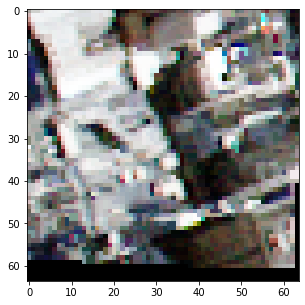

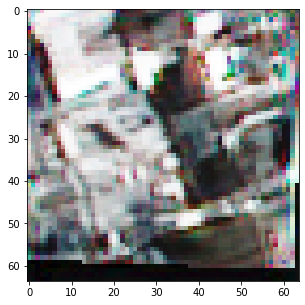

In [379]:
id = 3
gt1, sr1 = batch_gt[id], batch_sr[id]

viz(np.asarray(gt1[:3, ...].permute(1, 2, 0)), figsize=(5, 5))
viz(np.asarray(sr1[:3, ...].permute(1, 2, 0)), figsize=(5, 5))

# 验证效果
## batchify
与训练时的大小一致，ms是16x16，pan是64x64，但是效果不好

In [394]:
import cv2
import einops


# batchify
def batchify(d, blur=False):
    if d.ndim == 2:
        d = d[..., np.newaxis]
    d = d.transpose(-1, 0, 1)[np.newaxis, ...]
    if d.shape[-1] == 256:
        p = 64
    else:
        p = 16

    d_batched = einops.rearrange(d, 'b c (h i) (w j) -> (b h w) c i j', i=p, j=p)
    if blur:
        for i, img in enumerate(d_batched):
            d_batched[i] -= cv2.boxFilter(img, -1, (5, 5))

    d_batched = d_batched.astype('float32')
    d_batched = torch.tensor(d_batched, dtype=torch.float32)
    return d_batched / 2047.


t_gt_batch = batchify(t_gt)
t_ms_batch = batchify(t_ms, blur=True)
t_lms_batch = batchify(t_lms)
t_pan_batch = batchify(t_pan, blur=True)

print(t_gt_batch.shape)

torch.Size([16, 8, 64, 64])


(64, 64, 8)
(64, 64, 8)


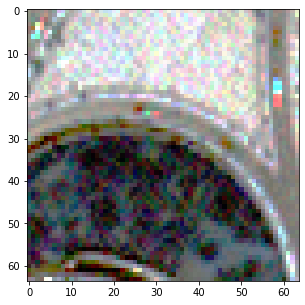

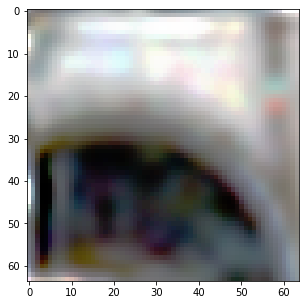

In [382]:
viz(np.array(t_gt_batch[0].permute(1, 2, 0)), figsize=(5, 5))
viz(np.array(t_lms_batch[0].permute(1, 2, 0)), figsize=(5, 5))

In [383]:
def to_device(*args):
    out = []
    for a in args:
        out.append(a.to(device))
    return out


t_gt_batch, t_ms_batch, t_lms_batch, t_pan_batch = to_device(t_gt_batch, t_ms_batch, t_lms_batch, t_pan_batch)
pannet.eval()
out = pannet(t_ms_batch, t_pan_batch)
sr = out + t_lms_batch
loss = criterion(sr, t_gt_batch)
print(loss)


tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


(64, 64, 3)
(64, 64, 3)


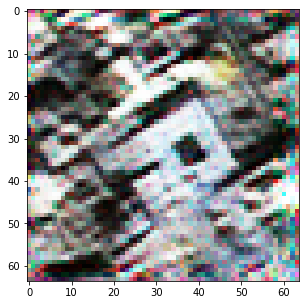

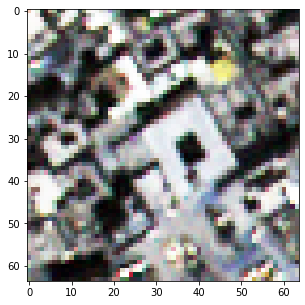

In [388]:
id = 3

sr, gt = to_cpu(sr, t_gt_batch)
viz(np.array(sr[id, :3, ...].permute(1, 2, 0)), figsize=(5, 5))
viz(np.array(gt[id, :3, ...].permute(1, 2, 0)), figsize=(5, 5))

(256, 256, 8)
(256, 256, 8)


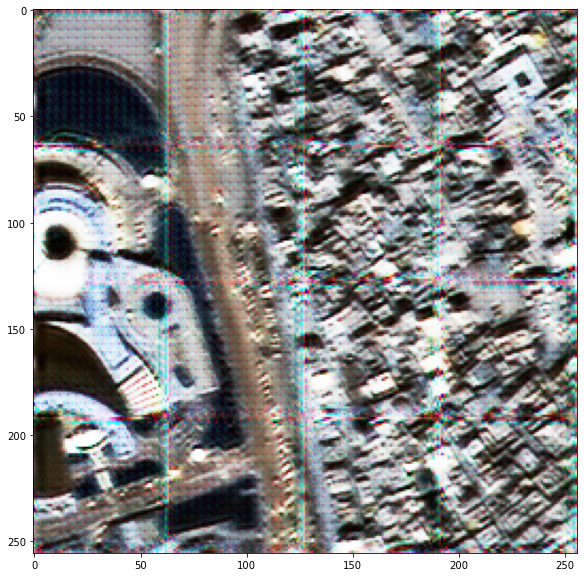

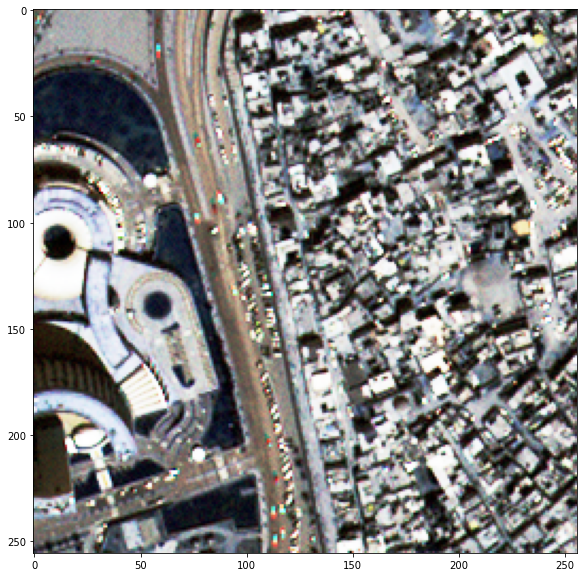

In [386]:
sr_full_res = einops.rearrange(sr, '(b h w) c i j -> b (h i) (w j) c', h=4, w=4)
viz(np.array(sr_full_res[0]))
viz(t_gt)

# 直接在原图上预测

In [403]:
'''
t_gt
t_ms
t_lms
t_pan

(256, 256, 8)
(64, 64, 8)
(256, 256, 8)
(256, 256)
'''

def to_float(d):
    return d.astype('float32')


t_ms1 = t_ms - cv2.boxFilter(t_ms, -1, (5, 5))
t_pan1 = t_pan - cv2.boxFilter(t_pan, -1, (5, 5))

t_gt1 = torch.tensor(to_float(t_gt), dtype=torch.float32).unsqueeze(0).permute(0, -1, 1, 2) / 2047.
t_ms1 = torch.tensor(to_float(t_ms1), dtype=torch.float32).unsqueeze(0).permute(0, -1, 1, 2) / 2047.
t_lms1 = torch.tensor(to_float(t_lms), dtype=torch.float32).unsqueeze(0).permute(0, -1, 1, 2) / 2047.
t_pan1 = torch.tensor(to_float(t_pan1), dtype=torch.float32)[None, None, ...] / 2047.
t_gt1, t_ms1, t_lms1, t_pan1 = to_device(t_gt1, t_ms1, t_lms1, t_pan1)

print_shape(t_gt1, t_ms1, t_lms1, t_pan1)

torch.Size([1, 8, 256, 256])
torch.Size([1, 8, 64, 64])
torch.Size([1, 8, 256, 256])
torch.Size([1, 1, 256, 256])


In [404]:
sr = pannet(t_ms1, t_pan1)
sr += t_lms1
criterion(sr, t_gt1)


tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)

(256, 256, 8)
(256, 256, 8)


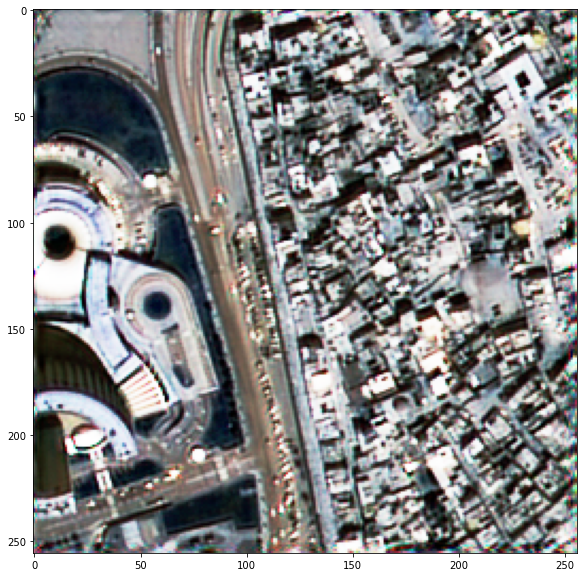

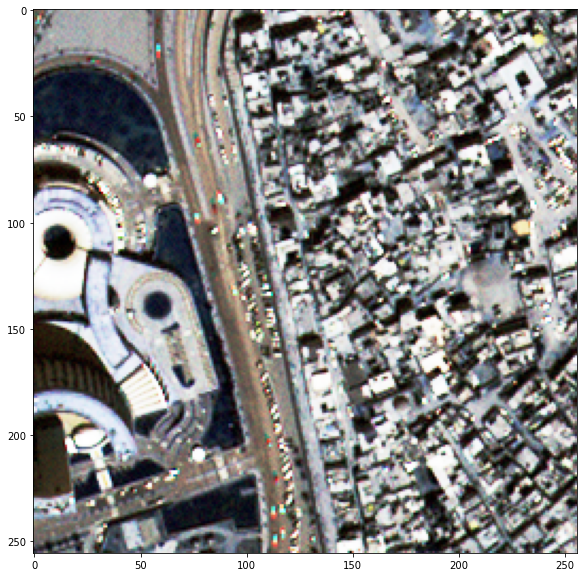

In [409]:
viz(np.array(sr.permute(0, 2, 3, 1)[0].detach().cpu()))
viz(t_gt)